# Functional model

In [1]:
#TODO: printing methods
#TODO: use Enums (?)
#TODO function to link parameters across populations (generate only once)
#TODO to_dataframeobj()
#TODO return self in population methods for chaining
#TODO remove unnecessary kwargs
#TODO black lines when plotting 'both' with 'day'

In [10]:
from math import ceil
from copy import copy
from warnings import warn
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib import colors as mcolors
from numpy import random
import numpy as np
np.set_printoptions(edgeitems=30, linewidth=100000)
seed = 3 # chosen by fair dice roll. guaranteed to be random. https://xkcd.com/221/

In [11]:
# Simulations study parameters
FMIN = 6 #minimum possible visual score
SMIN = 0 #minimum possible symptom score
NDAYS = 160 #number of days in the study
FIRSTVISIT = 8
LASTVISIT = NDAYS-1

In [3]:
#helper functions
def truncatednormal(xmin, xmax, pmsigma=3, shape=(2,4)):
    my_mean = (xmax+xmin)/2
    my_std = (xmax-xmin)/(2*pmsigma)
    
    vals = np.random.normal(my_mean, my_std, shape)
    invalid = np.flatnonzero((vals < xmin) | (vals >= xmax))
    
    while(len(invalid) > 0):
        vals.flat[invalid] = np.random.normal(my_mean, my_std, len(invalid))
        invalid = np.flatnonzero((vals < xmin) | (vals >= xmax))
        
    return vals

def rgblist_to_rgbapop(rgblist, npersons, ndays, opacity=1.0):
    '''
    takes a list of rgb colors with shape=(len,3) and turns it into an array of rgba colors with shape=(npersons, ndays, 4)
    where values change row-by-row (different persons) but are same across different columns (different days)
    '''
    listcopies = ceil(npersons/len(rgblist))
    rgblist_extended = np.tile(rgblist, (listcopies,1))[:npersons]
    rgbpop = np.tile(rgblist_extended, (1, 1, ndays)).reshape(npersons, ndays, 3)
    opacitypop = np.full((npersons, ndays, 1), opacity)
    rgbapop = np.concatenate([rgbpop, opacitypop], axis=2)
    return rgbapop

def normalize(array):
    return (array - np.min(array))/(np.max(array)-np.min(array))

In [13]:
from types import MethodType

class Population:
    def __init__(self, size=10000, title=''):
        
        self.title = title
        self.size = size
        
        self.parameter_generators = {}
        self.parameters = {}
        self.function_generators = {}
        
        self.days = np.tile(np.arange(NDAYS), (self.size,1))
        self.scores = {'visual':None, 
                       'symptom_noerror':None, 
                       'symptom':None}
        
    #Data generation methods

    def set_parameter_generator(self, paramname, func, paramtype):
        '''
        func must be a numpy function with the "shape" argument of the numpy function as the only argument to func
        paramtype must be either "population", "person", or "day"
        '''
        if func.__code__.co_varnames != ('shape',):
            raise ValueError("The function for parameter generation should only have 'shape' as an argument. "+
                             "Currently, it's arguments are: "
                            +", ".join(["'"+str(arg)+"'" for arg in func.__code__.co_varnames]))
        
        if paramtype == 'population':
            shape = (1,)
        elif paramtype == 'person':
            shape = (self.size, 1)
        elif paramtype == 'day':
            shape = (self.size, NDAYS)
        self.parameter_generators[paramname] = lambda: func(shape)
    def generate_parameters(self):
        '''generates all parameters
        if population was already generated, is resets the scores (since they were based on previous parameters)
        '''
        #generate
        for paramname in self.parameter_generators.keys():
            self.parameters[paramname] = self.parameter_generators[paramname]()
        #reset previous scores
        self.scores = {scorename:None for scorename in self.scores}   
    
    def set_score_generator(self, scorename, func):
        '''scorename is either visual, symptom_noerror, or symptom'''
        if scorename not in self.scores: warn("Scorename '{}' not known. Known options are: {}".format(scorename, self.scores.keys()))
        self.function_generators[scorename] = func
    def generate_from_score_generator(self, scorename):
        '''scorename is either visual, symptom_noerror, or error'''
        func = self.function_generators[scorename]
        paramnames = func.__code__.co_varnames
        paramvals = []
        for paramname in paramnames:
            #reserved parameters
            if paramname == 't' or paramname == 'day':
                paramvals.append(self.days)
            elif paramname == 'f' or paramname == 'visual':
                paramvals.append(self.scores['visual'])
            elif paramname == 's' or paramname == 'symptom_noerror':
                paramvals.append(self.scores['symptom_noerror'])
            #custom parameters
            else:
                paramvals.append(self.parameters[paramname])
        return func(*paramvals)
    
    def generate(self, generate_parameters=True):
        if generate_parameters: self.generate_parameters()
        
        for scorename in self.scores: #cannot be done by dict comprehension since later dict values depend on previous ones
            self.scores[scorename] = self.generate_from_score_generator(scorename)
        
        minvisualscore = np.min(self.scores['visual'])
        if minvisualscore < FMIN: 
            warn("visual score in {} has min={}, which is below FMIN={}".format(self.title, minscore, FMIN))
        minsymptomscore = np.min(self.scores['symptom'])
        if minsymptomscore < SMIN: 
            warn("symptom score in {} has  min={}, which is below SMIN={}".format(self.title, minscore, SMIN))
            
        #if all parameters are 'population', the generation process will only have created a single row
        #so, repeat that row 'self.size' times to create the full matrix            
        for scorename in self.scores:
            if self.scores[scorename].shape != self.days.shape: np.broadcast_to(self.scores[scorename], self.days.shape)
    
    #Non-data-generation methods
    
    def recalculate_size(self):
        #TODO try-catch for if not generated yet
        self.size = self.days.shape[0]
        
    def copy(self, newtitle=None, addtitle=None):
        '''not fully deep, but allows re-generation and filtering'''
        newpop = copy(self) #python shallow copy
        if newtitle is not None:
            newpop.title = newtitle
        if addtitle is not None:
            newpop.title += ' '+addtitle
        newpop.parameter_generators = copy(self.parameter_generators)
        newpop.function_generators = copy(self.function_generators)
        newpop.scores = copy(self.scores)
        return newpop
    
    def double(self, newtitle1=None, addtitle1=None, newtitle2=None, addtitle2=None):
        newpop2 = self.copy(newtitle=newtitle2, addtitle=addtitle2)
        newpop1 = self
        if newtitle1 is not None:
            newpop1.title = newtitle1
        if addtitle1 is not None:
            newpop1.title += ' '+addtitle1
        return newpop1, newpop2
    
    #removing outliers
    def filter(self, recovered_symptom_score=SMIN, firstday=FIRSTVISIT, lastday=NDAYS, copy=False):
        if copy==False: pop=self
        elif copy==True: pop=self.copy(addtitle='filtered')
        else: raise ValueError()
        
        persons_recovered_early = np.any(pop.scores['symptom'][:,:firstday] <= recovered_symptom_score, axis=1)
        persons_recovered_late = np.min(pop.scores['symptom'][:,:lastday], axis=1) > recovered_symptom_score
        persons_excluded = np.logical_or(persons_recovered_early, persons_recovered_late)
        persons_included = np.logical_not(persons_excluded)

        #take only the included and recalculate size
        pop.scores = {scorename:pop.scores[scorename][persons_included] for scorename in pop.scores}
        pop.recalculate_size()
        pop.days = pop.days[persons_included]
        
        return pop #may be self or a copy
    
    #plotting
    def plot(self, ax, ndays=None, npersons=None, x='day', y='symptom', viztype='lines', vizcolor='person'):
        #x and y are either 'day' or a scorename (either 'visual', 'symptom_noerror', or 'symptom')
        #viztype is either 'lines', 'points', or 'both'
        #vizcolor is either 'person' (each person is a color) or 'day' (each day is a color)
        
        if ndays is None: ndays=self.days.shape[1]
        if npersons is None: npersons=self.size
            
        if (viztype=='lines' or viztype=='both') and vizcolor=='day':
            warn('vizcolor of "day" can only be applied to points, not lines')
        if vizcolor != 'person' and vizcolor != 'day':
            raise ValueError()
            
        #abscissas
        if x=='day':
            x = self.days[:npersons, :ndays]
            xlabel='days since concussion'
        elif x in self.scores:
            xlabel = x+' scores'
            x = self.scores[x][:npersons, :ndays]
        else:
            raise ValueError()
            
        #ordinates
        if y=='day':
            x = self.days[:npersons, :ndays]
            ylabel='days since concussion'
        elif y in self.scores:
            ylabel = y+' scores'
            y = self.scores[y][:npersons, :ndays]
        else:
            raise ValueError()
            
        #titles and labels
        ax.set(title=self.title, xlabel=xlabel, ylabel=ylabel)
        
        #plotting
        if viztype=='lines' or viztype=='both':
            points = np.stack([x, y], axis=2)
            colors = mpl.cm.get_cmap('Dark2').colors # https://matplotlib.org/2.0.1/users/colormaps.html
            ax.add_collection(LineCollection(points, colors=colors))
            
        if viztype=='points' or viztype=='both':
            if vizcolor == 'person':
                colors = np.array(mpl.cm.get_cmap('Dark2').colors) # not the right shape. https://matplotlib.org/2.0.1/users/colormaps.html
                colors = rgblist_to_rgbapop(colors, npersons, ndays)
                colors = colors.reshape(npersons*ndays, 4) #scatter converts the 2d arrays x and y to flat arrays, and colors should respect that flatness
            elif vizcolor == 'day':
                colors = self.days[:npersons, :ndays]
                cmap = mpl.cm.get_cmap('viridis') # https://matplotlib.org/2.0.1/users/colormaps.html
                colors = cmap(normalize(colors)) # converts scalars to rgba
                colors = colors.reshape(npersons*ndays, 4) #scatter converts the 2d arrays x and y to flat arrays, and colors should respect that flatness
            else:
                raise ValueError("vizcolor of '{}' unknown".format(vizcolor))
            ax.scatter(x, y, facecolors='none', edgecolors=colors)
        ax.autoscale()

# Population generation

In [14]:
# Various functions to create populations

def get_default_pop(size=10000):
    pop = Population(size, 'default pop')        

    #visual score
    gen_visualscores = lambda t,r,f0: np.maximum(-r*t+f0, FMIN)
    pop.set_score_generator('visual', gen_visualscores)
    gen_r = lambda shape: 1
    pop.set_parameter_generator('r', gen_r , 'person')
    gen_f0 = lambda shape: 16
    pop.set_parameter_generator('f0', gen_f0, 'person')

    #symptom score no error
    gen_symptomscores = lambda f,a: a*(f-FMIN)
    pop.set_score_generator('symptom_noerror', gen_symptomscores)
    gen_a = lambda shape: 1
    pop.set_parameter_generator('a', gen_a, 'population')

    #symptom error
    gen_error_mult = lambda s,C: s*C
    pop.set_score_generator('symptom', gen_error_mult)
    gen_C = lambda shape: 1
    pop.set_parameter_generator('C', gen_C, 'day')

    return pop

def get_poster_pop(size=10000):
    pop = Population(size, 'poster pop')        

    #visual score
    gen_visualscores = lambda t,r,f0: np.maximum(-r*t+f0, FMIN)
    pop.set_score_generator('visual', gen_visualscores)
    gen_r = lambda shape: 2
    pop.set_parameter_generator('r', gen_r , 'population')
    gen_f0 = lambda shape: np.random.randint(14, 18+1, size=shape)
    pop.set_parameter_generator('f0', gen_f0, 'person')

    #symptom score no error
    gen_symptomscores = lambda f,a,s0: np.maximum(a*f+s0, SMIN)
    pop.set_score_generator('symptom_noerror', gen_symptomscores)
    gen_a = lambda shape: 1
    pop.set_parameter_generator('a', gen_a, 'population')
    gen_s0 = lambda shape: np.random.normal(6, 2, size=shape)
    pop.set_parameter_generator('s0', gen_s0, 'person')

    #symptom error
    gen_error_mult = lambda s,C: s*C
    pop.set_score_generator('symptom', gen_error_mult)
    gen_C = lambda shape: 1 + np.random.choice([-1, 1], size=shape)*(np.random.randint(0, 30, size=shape)/100)
    pop.set_parameter_generator('C', gen_C, 'day')
    
    return pop

def get_prevsim_pop(size=10):
    pop = Population(size, 'previous simulation - basic pop')
    
    #visual score
    gen_visualscores = lambda t,r,f0: np.maximum(-r*t+f0, FMIN)
    pop.set_score_generator('visual', gen_visualscores)
    gen_r = lambda shape: 1
    pop.set_parameter_generator('r', gen_r , 'population')
    gen_f0 = lambda shape: truncatednormal(14, 18, 3, shape)
    pop.set_parameter_generator('f0', gen_f0, 'person')

    #symptom score no error
    gen_symptomscores = lambda f,a: a*(f-FMIN)
    pop.set_score_generator('symptom_noerror', gen_symptomscores)
    gen_a = lambda shape: random.choice([1, 2, 3], shape)
    pop.set_parameter_generator('a', gen_a, 'person')

    #symptom error
    gen_error_mult = lambda s,C: s*C
    pop.set_score_generator('symptom', gen_error_mult)
    gen_C = lambda shape: truncatednormal(0.8, 1.2, 3, shape)
    pop.set_parameter_generator('C', gen_C, 'day')
    
    return pop

def get_linpop(size=10000):
    pop = get_default_pop(size)
    pop.title = 'linear population with multiplicative error'
    
    #symptom error
    gen_error_mult = lambda s,C: s*C
    pop.set_score_generator('symptom', gen_error_mult)
    gen_C = lambda shape: truncatednormal(0.7, 1.3, 3, shape)
    pop.set_parameter_generator('C', gen_C, 'day')
    
    return pop

def get_exppop(size=10000):
    pop = get_linpop(size)
    pop.title = 'exponential population with multiplicative error'
    
    #symptom score no error
    gen_symptomscores = lambda f,a,f0,B: a*(f0-FMIN)*(B**f-B**FMIN)/(B**f0-B**FMIN)
    pop.set_score_generator('symptom_noerror', gen_symptomscores)
    gen_B = lambda shape: np.full(shape=shape, fill_value=1.5)
    pop.set_parameter_generator('B', gen_B, 'population')
    
    return pop

In [15]:
pop_with_visual_score = Population(100)
gen_visualscores = lambda t,r,f0: np.maximum(-r*t+f0, FMIN)
pop_with_visual_score.set_score_generator('visual', gen_visualscores)
gen_r = lambda shape: truncatednormal(1/15, 31/15, 3, shape)
gen_f0 = lambda shape: truncatednormal(14, 18, 3, shape)
pop_with_visual_score.set_parameter_generator('r', gen_r, 'person')
pop_with_visual_score.set_parameter_generator('f0', gen_f0, 'person')

linear_pop = pop_with_visual_score.copy(newtitle='linear')
gen_symptomscores = lambda f,a: a*(f-FMIN)
linear_pop.set_score_generator('symptom_noerror', gen_symptomscores)
gen_a = lambda shape: 1
linear_pop.set_parameter_generator('a', gen_a, 'population')

exponential_pop = linear_pop.copy(newtitle='exponential')
gen_symptomscores = lambda f,a,f0,B: a*(f0-FMIN)*(B**f-B**FMIN)/(B**f0-B**FMIN)
exponential_pop.set_score_generator('symptom_noerror', gen_symptomscores)
exponential_pop.set_parameter_generator('a', gen_a, 'population')

B = 1.5
exponential_quick_pop, exponential_slow_pop = exponential_pop.double(addtitle1='quick', addtitle2='slow')
exponential_quick_pop.set_parameter_generator('B', lambda shape: B, 'population')
exponential_slow_pop.set_parameter_generator('B', lambda shape: 1/B, 'population')

gen_error_mul = lambda s,C: s*C
gen_C_mul = lambda shape: truncatednormal(0.7, 1.3, 3, shape)
gen_error_add = lambda s,C: np.maximum(s+C, SMIN)
gen_C_add = lambda shape: truncatednormal(-1, 1, 3, shape)


pops_noerror = [linear_pop, exponential_quick_pop, exponential_slow_pop]
pops_mulerror = []
pops_adderror = []

for i in range(len(pops_noerror)):
    pop_mul, pop_add = pops_noerror[i].double(addtitle1='multiplicative error', addtitle2='additive error')
    
    pop_mul.set_score_generator('symptom', gen_error_mul)
    pop_mul.set_parameter_generator('C', gen_C_mul, 'day')
    pop_mul.generate()
    pops_mulerror.append(pop_mul)
    
    pop_add.set_score_generator('symptom', gen_error_add)
    pop_add.set_parameter_generator('C', gen_C_add, 'day')
    pop_add.generate()
    pops_adderror.append(pop_add)

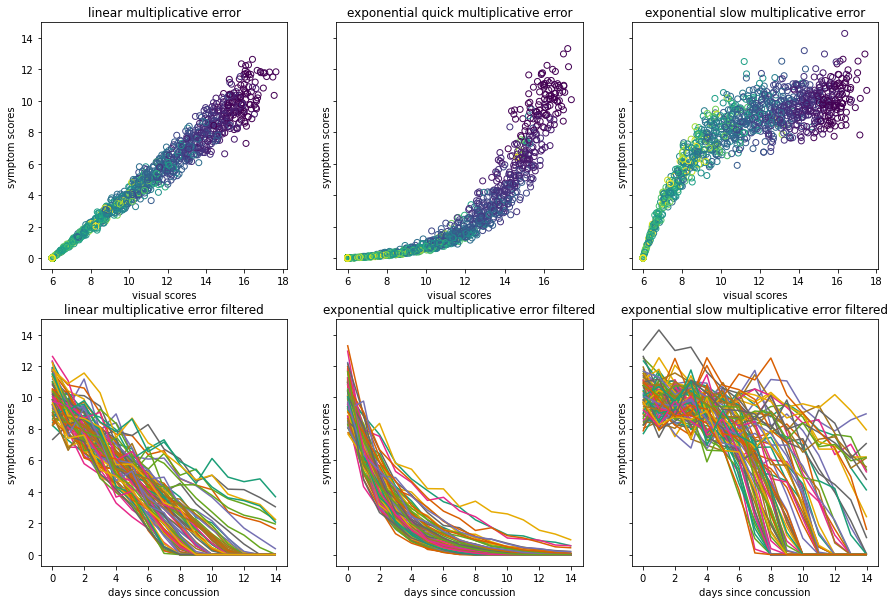

In [16]:
ncols = len(pops_noerror)
nrows = len([pops_mulerror, pops_adderror])

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=plt.figaspect(nrows/ncols)*2.5, sharey=True)
npersons=None
ndays=15

for i in range(ncols):
    pops_mulerror[i].plot(axes[0, i], x='visual', y='symptom', viztype='points', vizcolor='day', npersons=npersons, ndays=ndays)
    pops_mulerror[i].filter(lastday=50, copy=True).plot(axes[1, i], x='day', y='symptom', npersons=npersons, ndays=ndays)
    #pops_adderror[i].plot(axes[1, i], x='day', y='symptomscore', npersons=npersons, ndays=ndays)
    
plt.show()

# Study

In [19]:
#TODO not only first dip, but multiple consecutive days

class Study:
    
    def __init__(self, title='', sample_args=[8, 15, 29], smilescorename='symptom'):
        '''
        Sample args that are integers are interpreted as a fixed day
        Sample args between 0 and 1 (exclusive) are interpreted as a percentage with which to use SMILE, based on the first fixed day
        Sample args that do not fit the above criteria are ignored
        smilescore determines which score the milestone_ratios will be based on (can be symptom, visual, or symptom_noerror)
        '''
        
        self.title=title
        self.smilescorename=smilescorename
        
        sample_args = np.array(sample_args)
        self.fixed_days = sample_args[sample_args == sample_args.astype(int)].astype(int)
        self.milestone_ratios = sample_args[(0 < sample_args) & (sample_args < 1)]
        
        if self.fixed_days.size==0: 
            raise Exception("No fixed days in sample_args, which were {}".format(sample_args))
        
        if np.max(self.fixed_days) >= NDAYS:
            raise Exception("There is a fixed sample day in {} that is later than the LASTVISIT of {}".format(self.fixed_days, NDAYS))
        if np.max(self.fixed_days) > LASTVISIT:
            warn("There is a fixed sample day in {} that is later than the LASTVISIT of {}".format(self.fixed_days, LASTVISIT))
        if np.min(self.fixed_days) < FIRSTVISIT:
            warn("There is a fixed sample day in {} that is earlier than the FIRSTVISIT of {}".format(self.fixed_days, FIRSTVISIT))
            
        # list of sampled populations, where days and scores of samplepop are set by sample(samplepop)
        self.samples = []
        
    def sample(self, population, filter_args=None):
        #possible filtering
        if filter_args is not None: population = population.filter(**filter_args, copy=True)
                 
        # MILESTONES        
        
        smilescores = population.scores[self.smilescorename]
                 
        index = np.min(self.fixed_days) #day which milestone_ratios are based on
        smilescores_at_index = smilescores[:, index].reshape(-1, 1) #reshape to be vertical
        smile_vals = smilescores_at_index*self.milestone_ratios #The score values to reach. Each row is a person, each column is a milestone
        
        milestone_days = np.empty_like(smile_vals, dtype=int) #will hold the day each milestone_ratio is reached for each person
        for milestone_col in range(smile_vals.shape[1]):
            milestone_vals = smile_vals[:,milestone_col].reshape(-1, 1) #reshape to be vertical
            milestone_days[:,milestone_col] = np.argmax(smilescores <= milestone_vals, axis=1).astype(int) #the day at which the milestone is reached for each person
        #careful: values of 0 in milestone_days might represent 'day 0' or might represent 'never reached milestone'
        
        #Sample at those days
        milestone_smilescores = np.take_along_axis(smilescores, milestone_days, axis=1)
        milestone_scores = {scorename:np.take_along_axis(population.scores[scorename], milestone_days, axis=1) for scorename in population.scores}
        #replace the 'fake' days and scores with NaN
        notFake = (milestone_smilescores <= smile_vals)
        milestone_days = np.where(notFake, milestone_days, np.nan)
        milestone_scores = {scorename:np.where(notFake, milestone_scores[scorename], np.nan) for scorename in milestone_scores}
        
        # FIXED
        
        fixed_days = np.tile(self.fixed_days, (smilescores.shape[0],1)) #same shape as milestone_days
        fixed_scores = {scorename:np.take_along_axis(population.scores[scorename], fixed_days, axis=1) for scorename in population.scores}
        
        # COMBINE fixed and milestones
        
        samplepop = population.copy(addtitle='samples')
        samplepop.days = np.concatenate([fixed_days, milestone_days], axis=1)
        samplepop.scores = {scorename:np.concatenate([fixed_scores[scorename], milestone_scores[scorename]], axis=1) for scorename in samplepop.scores}
        self.samples.append(samplepop)
        
    def copy(self, newtitle=None, addtitle=None):
        '''not fully deep, but allows re-generation and filtering'''
        newstudy = copy(self) #python shallow copy
        if newtitle is not None:
            newstudy.title = newtitle
        if addtitle is not None:
            newstudy.title += ' '+addtitle
        newstudy.samples = copy(self.samples)
        return newstudy
                 
    #TODO analyze method
                 
    #TODO compare_analysis classmethod

## Comparing traditional studies

In [54]:
studies = [Study('trad short', [8, 15, 29]), Study('trad long', [8, 29, 90])]

for pop in pops_mulerror:
    for study in studies:
        study.sample(pop)

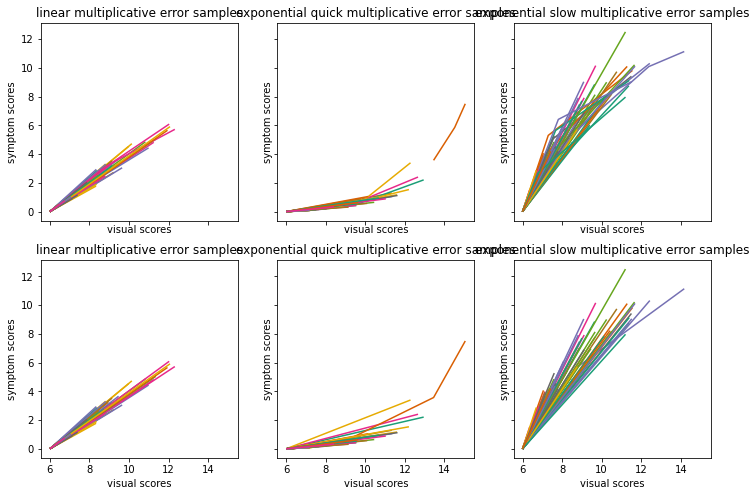

In [55]:
ncols = len(studies[0].samples)
nrows = len(studies)

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=plt.figaspect(nrows/ncols)*2, sharex=True, sharey=True)
npersons=None
ndays=None

for col in range(ncols):
    for row in range(nrows):
        studies[row].samples[col].plot(axes[row, col], x='visual', y='symptom', viztype='lines', vizcolor='person', npersons=npersons, ndays=ndays)
    
plt.show()

## Comparing traditional to smile studies

In [56]:
studies = [Study('trad short', [8, 15, 29, 90]), Study('smile', [8, 0.7, 0.4, 0.1])]

for pop in pops_mulerror:
    for study in studies:
        study.sample(pop)

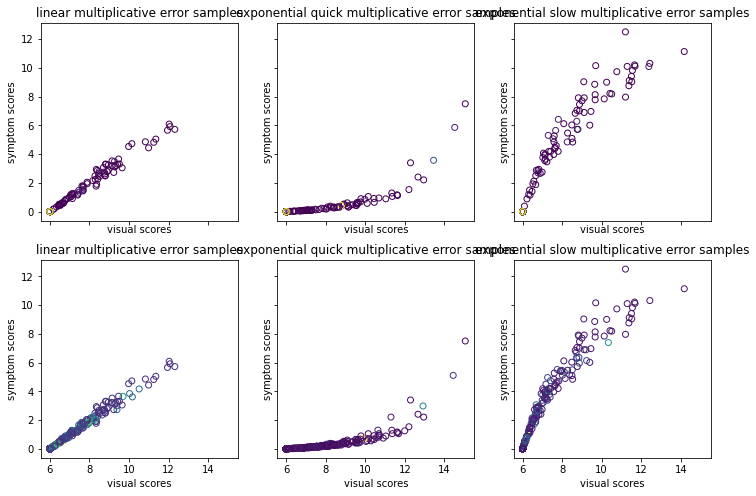

In [57]:
ncols = len(studies[0].samples)
nrows = len(studies)

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=plt.figaspect(nrows/ncols)*2, sharex=True, sharey=True)
npersons=None
ndays=None

for col in range(ncols):
    for row in range(nrows):
        studies[row].samples[col].plot(axes[row, col], x='visual', y='symptom', viztype='points', vizcolor='day', npersons=npersons, ndays=ndays)
    
plt.show()